In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# Useful Links
Implementing data object for neural networks:
https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

Writing a custom dataset class: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Writing a GAT Class example: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

Dataloaders for Batch Training: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [2]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [3]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [4]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Getting network pairs from interaction file
file = open('9606.protein.links.v12.0.txt', 'r')
lines = file.readlines()
lines.pop(0)

network_pairs = set()

for line in tqdm(lines):
    line = line.strip().split(' ')
    #print(line)
    
    if int(line[2]) >= 700:
    
        try:
            p1 = string_2_protein[line[0]]
            p2 = string_2_protein[line[1]]
            
            network_pairs.add((p1, p2))
        
        except KeyError:
            continue
        

100%|██████████| 13715404/13715404 [00:10<00:00, 1356065.37it/s]


In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.nn import GATConv
import torch.nn as nn

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        
        self.conv1 = GATConv(in_channels, out_channels, heads, dropout = 0.6)
        self.output_layer = nn.Linear(hidden_channels*out_channels, out_channels)
        #self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)
        #print(self.conv1.weight.dtype)
        
    def forward(self, x, edge_index):
        #x = F.dropout(x, p=0.6)
        x = self.conv1(x, edge_index)
        #print(x.size())
        x = torch.flatten(x)
        x = self.output_layer(x)
        #print(x.size())
        x = F.softmax(x)
        #x = F.dropout(x, p=0.6)
        #x = self.conv2(x, edge_index)
        return x
        

In [8]:
filename = '9606.protein.links.v12.0.txt'

class EMT_Dataset(Dataset):
    def __init__(self, filename):
        #self.idx = 0
        
        file = open(filename, 'r')
        lines = file.readlines()
        lines.pop(0)
    
        string_2_index = dict()
        counter = 0
        for string_id in string_2_protein:
            string_2_index[string_id] = counter
            counter += 1
            
        list_network = list()
        self.node_features = list()
        self.list_outputs = list()
    
        print('Getting network tensor...')
        for line in tqdm(lines):
            line = line.strip().split(' ')
    
            if int(line[2]) >= 999:
    
                try:
                    id1 = string_2_index[line[0]]
                    id2 = string_2_index[line[1]]
                    list_network.append([id1, id2])
                    list_network.append([id2, id1])
        
                except KeyError:
                    continue
    
        print('Getting node features tensor...')
        T0_column_vals = [column for column in scRNA_data.columns if 'T0' in column]
        T8_column_vals = [column for column in scRNA_data.columns if 'T7' in column]
        #print(T8_column_vals)
        proteins = [string_2_protein[string_id] for string_id in string_2_index]
        
        for column in T0_column_vals:
            self.node_features.append([[scRNA_data.loc[protein, column]] for protein in proteins])
            self.list_outputs.append([1,0])
        #print(self.node_features[0])
        for column in T8_column_vals:
            #print('Hello')
            self.node_features.append([[scRNA_data.loc[protein, column]] for protein in proteins])
            self.list_outputs.append([0,1])
        
        #print([0, 1] in self.list_outputs)
        #print(len(self.node_features[0]))
        self.edge_index = torch.tensor(list_network).t().contiguous()
        self.node_features = torch.tensor(self.node_features, dtype=torch.float)
        self.list_outputs = torch.tensor(self.list_outputs, dtype=torch.float)                            
    
    def __getitem__(self, idx):
        graph = self.edge_index
        node_feature = torch.transpose(self.node_features[idx], 0, 1).t()
        output = self.list_outputs[idx]
        
        #self.idx += 1
        #if self.idx == len(self.node_features):
            #self.idx = 0
        
        return graph, node_feature, output
    
    def __len__(self):
        return len(self.node_features)
    
    def num_features(self):
        return self.node_features[0].shape[0]
    
    def num_classes(self):
        return self.list_outputs[0].shape[0]
    
    def shuffle(self):
        temp = list(zip(self.node_features, self.list_outputs))
        random.shuffle(temp)
        self.node_features, self.list_outputs = zip(*temp)
        self.node_features, self.list_outputs = list(self.node_features), list(self.list_outputs)

In [24]:
dataset = EMT_Dataset(filename)

  1%|          | 152958/13715404 [00:00<00:08, 1529519.47it/s]

Getting network tensor...


100%|██████████| 13715404/13715404 [00:08<00:00, 1563058.59it/s]


Getting node features tensor...


In [25]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [26]:
dataset.shuffle()

In [41]:
def train(model, dataloader, epochs, lr = 1e-8, weight_decay = 5e-4):
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss().to(device)
    model.train()
    optimizer.zero_grad()
    all_losses = []
    
    for _ in tqdm(range(epochs)):
        model = model.train()
        losses = []
        
        for (graph, node_features, output) in dataloader:
            optimizer.zero_grad()
            
            #graph, node_features, output = dataset.__getitem__(i)
            graph = graph.to(device)
            node_features = node_features.to(device)
            output = output.to(device)
    
            out = model(node_features, graph)
            #print(out, output)
            loss = criterion(out, output)
            loss.backward()
            optimizer.step()
            losses.append(loss)
            
        all_losses.append(sum(losses)/len(losses))
        
    plt.plot([i for i in range(1, epochs+1)], all_losses)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('GATConv E/M classification Training')
    plt.show()
        
        

In [42]:
model = GAT(1, dataset.num_features(), dataset.num_classes(), 1).to(device)

In [43]:
dataset.num_features(), dataset.num_classes()

(18840, 2)

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-7-89fd749cb75c>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 1000/1000 [29:09<00:00,  1.75s/it]


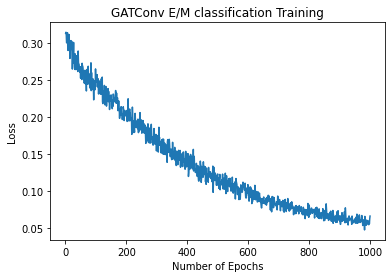

In [44]:
train(model, dataset, 1000)